In [1]:
import sys

sys.path.append('../')

In [2]:
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from pytorch_metric_learning.losses import NTXentLoss
from sentence_transformers import SentenceTransformer

from data import SGDDataset, get_dataloader
from model import Embedder
from train import GRUEmbedder, train_step

In [3]:
dataset = SGDDataset('../dstc8-schema-guided-dialogue', 1000)

C:\Users\Win_11\PycharmProjects\dialog-similarity\venv\lib\site-packages\transformers\models\marian\tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Augmenting...: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3848.87it/s]


In [4]:
embeddings_dir = '../conversation-similarity/cache'

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

model_name = 'all-mpnet-base-v2'
model = SentenceTransformer(model_name, device=device)
embedder = Embedder(model=model, tokenizer=None, device=device)

dataset.compute_embeddings(embeddings_dir, embedder, model_name)

del embedder

Computing embeddings...: 100%|████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 223.71it/s]


In [5]:
dataloader = get_dataloader(dataset, batch_size=32)
model = GRUEmbedder(input_dim=768, hidden_size=64).to(device)
optimizer = torch.optim.AdamW(model.parameters())
criterion = NTXentLoss()

In [6]:
n_epochs = 100

logs = {'Epoch': [], 'Loss': []}

for epoch in range(n_epochs):
    total_loss = 0
    for batch in dataloader:
        step_loss = train_step(
            model=model,
            batch=batch,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
        )
        total_loss += step_loss
    logs['Epoch'].append(epoch + 1)
    logs['Loss'].append(total_loss / len(dataloader))

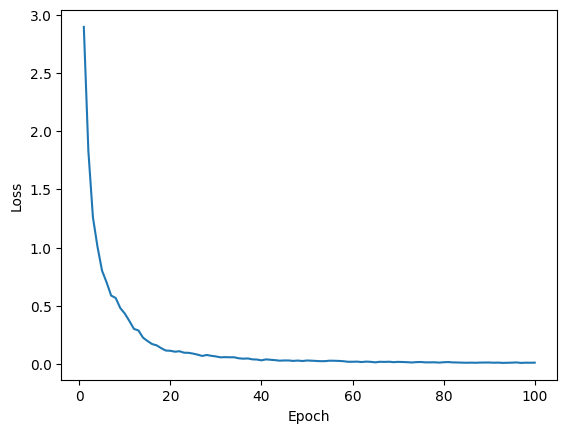

In [7]:
sns.lineplot(pd.DataFrame(logs), x='Epoch', y='Loss')
plt.show()